In [1]:
import paramiko
import pickle
import os
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
pd.set_option('display.max_columns',110)
pd.set_option('display.max_rows',None)

C:\Users\micha\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
hostname = "sftp.datashop.livevol.com"
port = 22
username = "nan2_lehigh_edu"
password = "PAIndex2023!"
remote_folder = "/subscriptions/order_000046197/item_000053507"
local_folder = os.path.join(os.getcwd(),"input")

In [3]:
def extract_zip(zip_filename, extraction_folder):
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        # Extract all files in the ZIP archive to the extraction folder
        zip_ref.extractall(extraction_folder)

In [4]:
def download_most_recent_zip(hostname, port, username, password, remote_folder, local_folder):
    # Create an SSH client
    ssh = paramiko.SSHClient()

    try:
        # Automatically add the server's host key
        ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())

        # Connect to the SSH server
        ssh.connect(hostname, port, username, password)

        # Open an SFTP session
        with ssh.open_sftp() as sftp:
            # Change to the remote folder
            sftp.chdir(remote_folder)

            # List files in the remote folder
            files = sftp.listdir()

            # Find the most recent ZIP file with "UnderlyingEOD" in the name
            most_recent_zip = None
            most_recent_date = datetime(1970, 1, 1)  # Initialize with a very old date

            for file in files:
                if file.startswith("UnderlyingEOD") and not "Summaries" in file:
                    try:
                        file_date = datetime.strptime(file.split("_")[-1].split(".")[0], "%Y-%m-%d")
                        if file_date > most_recent_date:
                            most_recent_date = file_date
                            most_recent_zip = file
                    except ValueError:
                        pass  # Ignore files with date parsing issues

            if most_recent_zip:
                # Replace backslashes with forward slashes in file paths
                remote_path = os.path.join(remote_folder, most_recent_zip).replace("\\", "/")
                local_path = os.path.join(local_folder, most_recent_zip).replace("\\", "/")

                # Download the most recent ZIP file
                sftp.get(remote_path, local_path)

                # Extract files from the downloaded ZIP file
                extract_zip(local_path, local_folder)

                # Clean up: Remove downloaded ZIP file
                os.remove(local_path)

    except Exception as e:
        print(f"Error: {e}")

    finally:
        # Close the SSH connection
        ssh.close()

In [5]:
# SFTP server details
sftp_hostname = "sftp.datashop.livevol.com"
sftp_port = 22  # Change the port if your SFTP server uses a different port
sftp_username = "nan2_lehigh_edu"
sftp_password = "PAIndex2023!"
sftp_remote_folder = "/subscriptions/order_000046197/item_000053507"  # Change to the actual path on the SFTP server
local_download_folder = os.path.join(os.getcwd(), "input")  # Set to "input" folder inside the current directory

# Create the local download folder if it doesn't exist
os.makedirs(local_download_folder, exist_ok=True)

# Download and extract the most recent ZIP file
download_most_recent_zip(sftp_hostname, sftp_port, sftp_username, sftp_password, sftp_remote_folder, local_download_folder)

In [6]:
input_file_path = os.path.join(os.getcwd(), "input/date_dataframes.pkl")

with open(input_file_path, 'rb') as input_file:
    date_dataframes = pickle.load(input_file)

In [7]:
#date_dataframes

In [8]:
local_download_folder = os.path.join(os.getcwd(), "input")  # Set to "input" folder inside the current directory

# List all CSV files in the "input" folder
csv_files = [file for file in os.listdir(local_download_folder) if file.startswith("UnderlyingEOD_") and file.endswith(".csv")]
sorted_csv_files = sorted(csv_files, key=lambda x: datetime.strptime(x.split("_")[-1].split(".")[0], "%Y-%m-%d"), reverse=True)

if sorted_csv_files:
    most_recent_csv = sorted_csv_files[0]
    csv_file_path = os.path.join(local_download_folder, most_recent_csv)

    date_format = most_recent_csv.split("_")[-1].split(".")[0]

    eod_df = pd.read_csv(csv_file_path)

    date_dataframes[date_format] = eod_df

    try:
        os.remove(csv_file_path)
        print(f"Deleted: {csv_file_path}")
    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
    except Exception as e:
        print(f"Error deleting file: {e}")
else:
    print("No CSV files found in the 'input' folder.")


Deleted: C:\Users\micha\OneDrive\Documents\Projects\PA100\PA-Index\input\UnderlyingEOD_2024-08-09.csv


In [9]:
start_2023 = '2023-11-10'
end_2023 = '2024-06-28'
start_2024 = '2024-06-28'

In [10]:
import warnings

df = pd.read_excel('input/RAY as of OCT 23 20231_PA.xlsx')
df = df.sort_values('Market Cap\n',ascending=False)
df.columns = df.columns.str.rstrip('\n')
df['Ticker'] = df['Ticker'].str.split(' ',n=1,expand=True)[0].replace(' ','')
float_df = df[['Ticker','Equity Float']].head(100)
float_df

eod_market_cap_pivot2023 = pd.DataFrame()

unique_dates = list(date_dataframes.keys())

for date in unique_dates:

    if date >= start_2023 and date <= end_2023:
    
        eod_df = date_dataframes[date]

        merged_df = pd.merge(float_df,eod_df,left_on='Ticker',right_on='underlying_symbol')

        merged_df['Market Cap'] = merged_df['Equity Float'] * merged_df['close']
    
        eod_market_cap_daily = merged_df.pivot_table(values='Market Cap',index='quote_date',columns='Ticker',aggfunc='sum')

        eod_market_cap_pivot2023 = pd.concat([eod_market_cap_pivot2023,eod_market_cap_daily])

eod_market_cap_pivot2023 = eod_market_cap_pivot2023.rename_axis(index='Date')
eod_market_cap_pivot2023.index = pd.to_datetime(eod_market_cap_pivot2023.index,errors='coerce')


eod_market_cap_pivot2023['mkt_cap_deleted_stock'] = 0

for ticker in float_df['Ticker']:
    last_valid_market_cap = None
    first_deletion = False

    for date_index, date in enumerate(eod_market_cap_pivot2023.index):

        if date != eod_market_cap_pivot2023.index[-1]:
        
            next_date = eod_market_cap_pivot2023.index[date_index + 1]
        
            market_cap = eod_market_cap_pivot2023.at[date,ticker]

            market_cap_next_date = eod_market_cap_pivot2023.at[next_date,ticker]

            if (pd.isna(market_cap) or market_cap == 0) and (pd.isna(market_cap_next_date) or market_cap_next_date == 0):
                if not first_deletion and last_valid_market_cap is not None:
                    eod_market_cap_pivot2023.at[date, 'mkt_cap_deleted_stock'] = last_valid_market_cap
                    first_deletion = True

            if (pd.isna(market_cap) or market_cap == 0) and market_cap_next_date != 0:
                if not first_deletion and last_valid_market_cap is not None:
                    eod_market_cap_pivot2023.at[date,ticker] = last_valid_market_cap
                    first_deletion = True
            
            else:
                last_valid_market_cap = market_cap
                first_deletion = False

        else:
            market_cap = eod_market_cap_pivot2023.at[date,ticker]
            if pd.isna(market_cap) or market_cap == 0:
                if not first_deletion and last_valid_market_cap is not None:
                    eod_market_cap_pivot2023.at[date,ticker] = last_valid_market_cap
                    first_deletion = True
            else:
                last_valid_market_cap = market_cap
                first_deletion = False

eod_market_cap_pivot2023["close_mkt_cap"] = eod_market_cap_pivot2023.drop(columns='mkt_cap_deleted_stock').sum(axis=1)


eod_market_cap_pivot2023["adj_mkt_cap"] = 0
eod_market_cap_pivot2023["divisor"] = 0
eod_market_cap_pivot2023["gross_index_level"] = 0
eod_market_cap_pivot2023["Index Value"] = 0


for i in range(0, len(eod_market_cap_pivot2023)):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        if i == 0:
            eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "adj_mkt_cap"] = float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "close_mkt_cap"]) + float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "mkt_cap_deleted_stock"])
            eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "divisor"] = 1
            eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "gross_index_level"] = float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "close_mkt_cap"]) / float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "divisor"])
            eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "Index Value"] = float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "gross_index_level"]) / (float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[0], "close_mkt_cap"]) / 100)
        else:
            eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "adj_mkt_cap"] = float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i-1], "close_mkt_cap"]) - float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "mkt_cap_deleted_stock"])
            eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "divisor"] = (float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "adj_mkt_cap"]) / float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i-1], "close_mkt_cap"])) * float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i-1], "divisor"])
            eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "gross_index_level"] = float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "close_mkt_cap"]) / float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "divisor"])
            eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "Index Value"] = float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "gross_index_level"]) / (float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[0], "close_mkt_cap"]) / 100)

C:\Users\micha\AppData\Local\Temp\ipykernel_51960\4277907380.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2938245904.56' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eod_market_cap_pivot2023.at[date, 'mkt_cap_deleted_stock'] = last_valid_market_cap


In [11]:
eod_market_cap_pivot2023

Ticker,AA,ACRS,AEO,AHCO,AME,ANSS,APD,ARMK,AUR,AVTR,AWI,AXTA,BDN,BSY,BV,CABA,CCNE,CEIX,CMCSA,CNX,COHR,COR,CRS,CTLP,CUBE,CUBI,DGICA,DKS,DORM,DUOL,ECVT,ENS,EPAM,EQT,ESNT,ETRN,FCF,FIVE,FMC,FNB,FOLD,FOUR,FULT,GLPI,GMED,HCSG,HLNE,HRMY,HSY,HT,HWM,IRT,KHC,KMT,KOP,KRYS,KWR,LMB,LNC,LTHM,MATW,MDGL,MLYS,MNTK,MPB,MSA,NVRI,NWBI,OFLX,OLLI,OSUR,PENN,PFIS,PNC,PPG,PPL,RDN,SEIC,SEM,STBA,TFX,TGI,TOL,UGI,UHS,UHT,URBN,UTZ,UVSP,VPG,VSH,VSTS,VTRS,WAB,WCC,WMK,WST,WTRG,X,YORW,mkt_cap_deleted_stock,close_mkt_cap,adj_mkt_cap,divisor,gross_index_level,Index Value
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-10,4.351981e+09,3.039768e+08,3.363481e+09,5.400685e+08,3.463898e+10,2.519369e+10,5.877773e+10,7.404130e+09,1.265278e+09,1.246463e+10,3.572802e+09,6.578822e+09,6.471881e+08,1.156966e+10,2.841525e+08,6.845609e+08,4.017577e+08,2.312523e+09,1.711415e+11,3.224744e+09,5.060722e+09,3.354949e+10,3.176607e+09,3.771882e+08,8.132981e+09,1.189177e+09,2.169072e+08,6.677289e+09,1.757105e+09,7.224892e+09,9.060021e+08,3.452831e+09,1.330967e+10,1.597466e+10,5.022412e+09,3.593891e+09,1.235885e+09,9.617555e+09,6.351075e+09,3.953858e+09,2.982597e+09,3.161326e+09,2.148591e+09,1.135825e+10,5.144362e+09,7.024324e+08,3.035520e+09,7.925971e+08,2.822223e+10,3.770825e+08,1.935364e+10,2.892871e+09,2.586828e+10,1.804297e+09,8.281160e+08,2.404068e+09,2.262460e+09,3.437257e+08,3.692588e+09,2.449280e+09,1.095228e+09,2.170715e+09,1.180018e+08,3.863620e+08,2.879356e+08,5.941452e+09,4.560458e+08,1.334157e+09,2.146614e+08,4.837328e+09,4.541105e+08,3.536423e+09,2.675167e+08,4.764296e+10,3.030724e+10,1.843560e+10,4.140823e+09,6.831256e+09,2.279472e+09,9.878336e+08,9.373991e+09,7.653333e+08,8.583942e+09,4.291579e+09,7.718202e+09,4.980319e+08,2.372199e+09,8.204063e+08,5.001413e+08,3.277203e+08,2.750659e+09,2.165152e+09,1.101429e+10,1.995867e+10,7.131015e+09,1.004864e+09,2.510139e+10,8.160424e+09,6.824687e+09,4.263299e+08,0.000000e+00,8.508403e+11,8.508403e+11,1.000000,8.508403e+11,100.000000
2023-11-13,4.344916e+09,4.113606e+07,3.269347e+09,5.958834e+08,3.477221e+10,2.513666e+10,5.867809e+10,7.406726e+09,1.286250e+09,1.249485e+10,3.539684e+09,6.662769e+09,6.261482e+08,1.151613e+10,2.843505e+08,6.677149e+08,3.987355e+08,2.294869e+09,1.694256e+11,3.220118e+09,5.035404e+09,3.377024e+10,3.255606e+09,3.760076e+08,8.066006e+09,1.192049e+09,2.158521e+08,6.553283e+09,1.759997e+09,7.292913e+09,9.224189e+08,3.473809e+09,1.327574e+10,1.624403e+10,5.004778e+09,3.657921e+09,1.253811e+09,9.360223e+09,6.349836e+09,3.939712e+09,2.945315e+09,3.247945e+09,2.157394e+09,1.130804e+10,5.098950e+09,7.134885e+08,3.019041e+09,8.079290e+08,2.870199e+10,3.770825e+08,1.966220e+10,2.791425e+09,2.613963e+10,1.786104e+09,8.169199e+08,2.430411e+09,2.286474e+09,3.342462e+08,3.669100e+09,2.308558e+09,1.091996e+09,2.289109e+09,1.167172e+08,5.205324e+08,2.901358e+08,6.040859e+09,4.470500e+08,1.335412e+09,2.141319e+08,4.867457e+09,4.597254e+08,3.420034e+09,2.711761e+08,4.730280e+10,3.041547e+10,1.815198e+10,4.111202e+09,6.786576e+09,2.276351e+09,9.944733e+08,9.553476e+09,7.886621e+08,8.502749e+09,4.291579e+09,7.671982e+09,4.961222e+08,2.292478e+09,8.237467e+08,5.005677e+08,3.350809e+08,2.692287e+09,2.126070e+09,1.070950e+10,2.006507e+10,7.107784e+09,1.000625e+09,2.483836e+10,8.109558e+09,6.763185e+09,4.265636e+08,0.000000e+00,8.487627e+11,8.508403e+11,1.000000,8.487627e+11,99.755815
2023-11-14,4.623979e+09,4.351668e+07,3.374342e+09,6.650625e+08,3.553711e+10,2.575537e+10,5.942319e+10,6.799234e+09,1.502955e+09,1.263924e+10,3.687613e+09,6.810782e+09,7.145159e+08,1.187518e+10,3.085084e+08,6.688635e+08,4.303684e+08,2.408052e+09,1.710598e+11,3.280263e+09,5.275185e+09,3.299760e+10,3.338412e+09,3.972577e+08,8.610735e+09,1.270179e+09,2.211278e+08,6.761541e+09,1.870967e+09,7.496291e+09,9.819298e+08,3.759427e+09,1.400979e+10,1.628893e+10,5.137548e+09,3.705426e+09,1.334477e+09,9.920585e+09,6.540715e+09,4.166051e+09,3.091577e+09,3.501183e+09,2.277427e+09,1.157417e+10,

In [12]:
last_value = eod_market_cap_pivot2023.iloc[-1]['Index Value']

# "#############################################"

In [13]:
import warnings

df = pd.read_excel('input/RAY as of JUL 01 20241_PA.xlsx')
df = df.sort_values('Market Cap\n',ascending=False)
df.columns = df.columns.str.rstrip('\n')
df['Ticker'] = df['Ticker'].str.split(' ',n=1,expand=True)[0].replace(' ','')
float_df = df[['Ticker','Equity Float']].head(100)
float_df

eod_market_cap_pivot2024 = pd.DataFrame()

unique_dates = list(date_dataframes.keys())

for date in unique_dates:

    if date >= start_2024:
    
        eod_df = date_dataframes[date]

        merged_df = pd.merge(float_df,eod_df,left_on='Ticker',right_on='underlying_symbol')

        merged_df['Market Cap'] = merged_df['Equity Float'] * merged_df['close']
    
        eod_market_cap_daily = merged_df.pivot_table(values='Market Cap',index='quote_date',columns='Ticker',aggfunc='sum')

        eod_market_cap_pivot2024 = pd.concat([eod_market_cap_pivot2024,eod_market_cap_daily])

eod_market_cap_pivot2024 = eod_market_cap_pivot2024.rename_axis(index='Date')
eod_market_cap_pivot2024.index = pd.to_datetime(eod_market_cap_pivot2024.index,errors='coerce')


eod_market_cap_pivot2024['mkt_cap_deleted_stock'] = 0

for ticker in float_df['Ticker']:
    last_valid_market_cap = None
    first_deletion = False

    for date_index, date in enumerate(eod_market_cap_pivot2024.index):

        if date != eod_market_cap_pivot2024.index[-1]:
        
            next_date = eod_market_cap_pivot2024.index[date_index + 1]
        
            market_cap = eod_market_cap_pivot2024.at[date,ticker]

            market_cap_next_date = eod_market_cap_pivot2024.at[next_date,ticker]

            if (pd.isna(market_cap) or market_cap == 0) and (pd.isna(market_cap_next_date) or market_cap_next_date == 0):
                if not first_deletion and last_valid_market_cap is not None:
                    eod_market_cap_pivot2024.at[date, 'mkt_cap_deleted_stock'] = last_valid_market_cap
                    first_deletion = True

            if (pd.isna(market_cap) or market_cap == 0) and market_cap_next_date != 0:
                if not first_deletion and last_valid_market_cap is not None:
                    eod_market_cap_pivot2024.at[date,ticker] = last_valid_market_cap
                    first_deletion = True
            
            else:
                last_valid_market_cap = market_cap
                first_deletion = False

        else:
            market_cap = eod_market_cap_pivot2024.at[date,ticker]
            if pd.isna(market_cap) or market_cap == 0:
                if not first_deletion and last_valid_market_cap is not None:
                    eod_market_cap_pivot2024.at[date,ticker] = last_valid_market_cap
                    first_deletion = True
            else:
                last_valid_market_cap = market_cap
                first_deletion = False

eod_market_cap_pivot2024["close_mkt_cap"] = eod_market_cap_pivot2024.drop(columns='mkt_cap_deleted_stock').sum(axis=1)


eod_market_cap_pivot2024["adj_mkt_cap"] = 0
eod_market_cap_pivot2024["divisor"] = 0
eod_market_cap_pivot2024["gross_index_level"] = 0
eod_market_cap_pivot2024["Index Value"] = 0


for i in range(0, len(eod_market_cap_pivot2024)):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        if i == 0:
            eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "adj_mkt_cap"] = float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "close_mkt_cap"]) + float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "mkt_cap_deleted_stock"])
            eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "divisor"] = 1
            eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "gross_index_level"] = float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "close_mkt_cap"]) / float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "divisor"])
            eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "Index Value"] = float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "gross_index_level"]) / (float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[0], "close_mkt_cap"]) / last_value)
        else:
            eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "adj_mkt_cap"] = float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i-1], "close_mkt_cap"]) - float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "mkt_cap_deleted_stock"])
            eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "divisor"] = (float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "adj_mkt_cap"]) / float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i-1], "close_mkt_cap"])) * float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i-1], "divisor"])
            eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "gross_index_level"] = float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "close_mkt_cap"]) / float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "divisor"])
            eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "Index Value"] = float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "gross_index_level"]) / (float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[0], "close_mkt_cap"]) / last_value)

# Reporting

In [29]:
eod_market_cap_pivot2023.tail(1)

Ticker,AA,ACRS,AEO,AHCO,AME,ANSS,APD,ARMK,AUR,AVTR,AWI,AXTA,BDN,BSY,BV,CABA,CCNE,CEIX,CMCSA,CNX,COHR,COR,CRS,CTLP,CUBE,CUBI,DGICA,DKS,DORM,DUOL,ECVT,ENS,EPAM,EQT,ESNT,ETRN,FCF,FIVE,FMC,FNB,FOLD,FOUR,FULT,GLPI,GMED,HCSG,HLNE,HRMY,HSY,HT,HWM,IRT,KHC,KMT,KOP,KRYS,KWR,LMB,LNC,LTHM,MATW,MDGL,MLYS,MNTK,MPB,MSA,NVRI,NWBI,OFLX,OLLI,OSUR,PENN,PFIS,PNC,PPG,PPL,RDN,SEIC,SEM,STBA,TFX,TGI,TOL,UGI,UHS,UHT,URBN,UTZ,UVSP,VPG,VSH,VSTS,VTRS,WAB,WCC,WMK,WST,WTRG,X,YORW,mkt_cap_deleted_stock,close_mkt_cap,adj_mkt_cap,divisor,gross_index_level,Index Value
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-06-28,7.026047e+09,71674525.44,3.611488e+09,7.853397e+08,3.829353e+10,2.776879e+10,5.709931e+10,8.826803e+09,1.929375e+09,1.423762e+10,5.000422e+09,7.548635e+09,753229350.8,1.100768e+10,526721708.8,2.859994e+08,4.112275e+08,2.467788e+09,1.600698e+11,3.753719e+09,1.078568e+10,3.826173e+10,5.208684e+09,3.892889e+08,1.008307e+10,1.377894e+09,1.941463e+08,1.274820e+10,2.405566e+09,7.114487e+09,9.224189e+08,4.176962e+09,1.064039e+10,1.509307e+10,5.826288e+09,5.357790e+09,1.376304e+09,5.924605e+09,7.133185e+09,4.837994e+09,2.839203e+09,4.049587e+09,2.717548e+09,1.135072e+10,7.972713e+09,7.790881e+08,4.165517e+09,1.005578e+09,2.708143e+10,NaN,3.033306e+10,4.180449e+09,2.534918e+10,1.862832e+09,738746670.8,4.483480e+09,2.342094e+09,5.396664e+08,5.212572e+09,NaN,7.356358e+08,4.387472e+09,214715545.2,341430912.0,322405717.2,6.958524e+09,6.750729e+08,1.450880e+09,1.701540e+08,6.033901e+09,2.975933e+08,2.888078e+09,288894960.0,6.156206e+10,2.962020e+10,2.010826e+10,4.850189e+09,7.813015e+09,3.647571e+09,1.231657e+09,9.856679e+09,1.160417e+09,1.229208e+10,4.768189e+09,1.095362e+10,498413795.4,2.751376e+09,1.111357e+09,6.492314e+08,3.559942e+08,2.804125e+09,1.595855e+09,1.271753e+10,2.799959e+10,8.003201e+09,1.023285e+09,2.419916e+10,9.040897e+09,7.499220e+09,4.333400e+08,0.0,9.316477e+11,9.277431e+11,0.996432,9.349840e+11,109.889485


In [30]:
eod_market_cap_pivot2024.head(1)

Ticker,AA,AEO,AHCO,AME,ANSS,APD,ARMK,AUR,AVBP,AVTR,AWI,AXTA,BDN,BSY,BV,CABA,CCNE,CEIX,CMCSA,CNX,COHR,COR,CRS,CTLP,CUBE,CUBI,DGICA,DKS,DORM,DUOL,ECVT,ENS,EPAM,EQT,ESNT,ETRN,FCF,FIVE,FMC,FNB,FOLD,FOUR,FULT,GLPI,GMED,HCSG,HLNE,HRMY,HSY,HWM,IRT,KHC,KMT,KOP,KRYS,KWR,LMB,LNC,LRMR,MATW,MDGL,MLYS,MNTK,MPB,MSA,NVRI,NWBI,OCGN,OFLX,OLLI,OSUR,PENN,PFIS,PNC,PPG,PPL,RDN,SEIC,SEM,STBA,TFX,TGI,TOL,UGI,UHS,UHT,URBN,UTZ,UVSP,VERX,VPG,VSH,VTRS,WAB,WCC,WMK,WST,WTRG,X,YORW,mkt_cap_deleted_stock,close_mkt_cap,adj_mkt_cap,divisor,gross_index_level,Index Value
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-06-28,7.058682e+09,3.586628e+09,8.148882e+08,3.841052e+10,2.787102e+10,5.712909e+10,8.875242e+09,2.158044e+09,191852899.5,1.431027e+10,4.896791e+09,7.509247e+09,747171632.8,7.556090e+09,779933333.2,3.382879e+08,4.102710e+08,2.239951e+09,1.521923e+11,3.529251e+09,1.085503e+10,3.871993e+10,5.292692e+09,4.088990e+08,1.007963e+10,1.385124e+09,1.969822e+08,1.199099e+10,2.359935e+09,7.447430e+09,9.346997e+08,4.088579e+09,1.054486e+10,1.619342e+10,5.801875e+09,5.322507e+09,1.372405e+09,5.839622e+09,7.126997e+09,4.842338e+09,2.895916e+09,4.436446e+09,3.015431e+09,1.174311e+10,7.652288e+09,7.720395e+08,4.653067e+09,9.013829e+08,2.665469e+10,3.130810e+10,4.182141e+09,2.489749e+10,1.830391e+09,749117501.2,4.613359e+09,2.343995e+09,5.531258e+08,5.234699e+09,297741232.8,7.355736e+08,5.081474e+09,282480166.8,333021474.0,3.219219e+08,6.971873e+09,6.764517e+08,1.446108e+09,3.874630e+08,318267689.4,5.990194e+09,3.025320e+08,2.918362e+09,290975985.0,6.149027e+10,2.956427e+10,2.010181e+10,4.623385e+09,7.778849e+09,3.573486e+09,1.234071e+09,9.877365e+09,1.165840e+09,1.172874e+10,4.771675e+09,1.048362e+10,4.974569e+08,2.774787e+09,1.075094e+09,6.460773e+08,2.074849e+09,3.460233e+08,2.758781e+09,1.261960e+10,2.755406e+10,7.893990e+09,1.023139e+09,2.386150e+10,9.376498e+09,7.621884e+09,434262330.6,0,9.231521e+11,9.231521e+11,1,9.231521e+11,109.889485


In [17]:
excel_file_path2023 = 'input/RAY as of Oct 23 20231_PA.xlsx'
df2023 = pd.read_excel(excel_file_path2023)
df2023 = df2023.sort_values('Market Cap\n',ascending=False)
df2023.columns = df2023.columns.str.rstrip('\n')
df2023['Ticker'] = df2023['Ticker'].str.split(' ',n=1,expand=True)[0].replace(' ','')
df2023 = df2023[df2023['Ticker'].isin(eod_market_cap_pivot2023.tail(1).keys()[:-6])][['Ticker','GICS Sector']]

excel_file_path2024 = 'input/RAY as of Jul 01 20241_PA.xlsx'
df2024 = pd.read_excel(excel_file_path2024)
df2024 = df2024.sort_values('Market Cap\n',ascending=False)
df2024.columns = df2024.columns.str.rstrip('\n')
df2024['Ticker'] = df2024['Ticker'].str.split(' ',n=1,expand=True)[0].replace(' ','')
df2024 = df2024[df2024['Ticker'].isin(eod_market_cap_pivot2024.head(1).keys()[:-6])][['Ticker','GICS Sector']]

In [18]:
gics2023 = eod_market_cap_pivot2023.tail(1).T.reset_index()
gics2023.columns=['Ticker','Market Cap']
gics2023 = pd.merge(gics2023,df2023, on = 'Ticker')

gics2024 = eod_market_cap_pivot2024.head(1).T.reset_index()
gics2024.columns=['Ticker','Market Cap']
gics2024 = pd.merge(gics2024,df2024, on = 'Ticker')

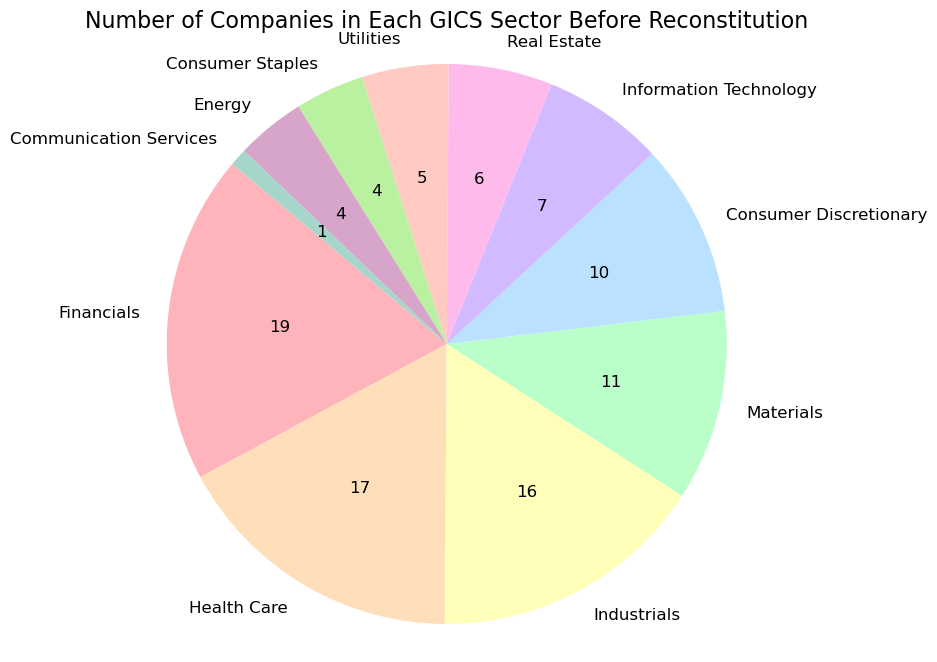

In [19]:
companies2023 = gics2023[['GICS Sector']].value_counts().to_frame().reset_index()
companies2023.columns = ['GICS Sector', 'Number of Companies']

# Define a set of distinct pastel colors
colors = [
    '#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF',
    '#D1BAFF', '#FFBAEC', '#FFCAC1', '#BAF1A1', '#D6A5C9',
    '#A5D6C9'
]

# Plotting with the distinct pastel colors
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(companies2023['Number of Companies'], labels=companies2023['GICS Sector'], autopct=lambda p: f'{int(round(p * sum(companies2023["Number of Companies"]) / 100))}', startangle=140, colors=colors)

# Customize the appearance
for text in texts:
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_fontsize(12)

plt.title('Number of Companies in Each GICS Sector Before Reconstitution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [20]:
print("Number of Companies in Each GICS Sector Before Reconstitution")
companies2023

Number of Companies in Each GICS Sector Before Reconstitution


,GICS Sector,Number of Companies
0,Financials,19
1,Health Care,17
2,Industrials,16
3,Materials,11
4,Consumer Discretionary,10
5,Information Technology,7
6,Real Estate,6
7,Utilities,5
8,Consumer Staples,4
9,Energy,4


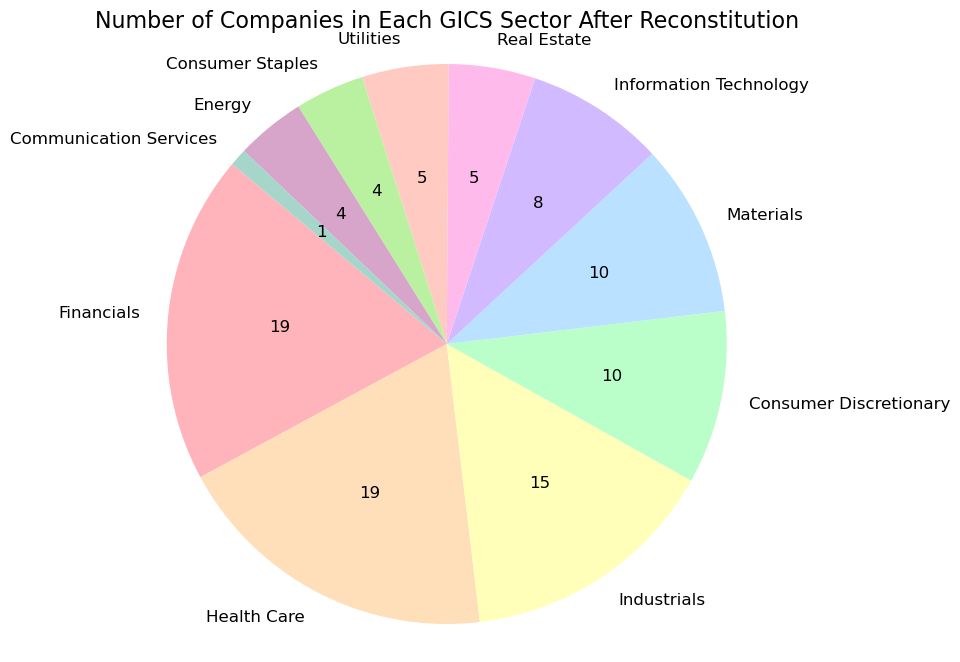

In [21]:
companies2024 = gics2024[['GICS Sector']].value_counts().to_frame().reset_index()
companies2024.columns = ['GICS Sector', 'Number of Companies']

# Define a set of distinct pastel colors
colors = [
    '#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF',
    '#D1BAFF', '#FFBAEC', '#FFCAC1', '#BAF1A1', '#D6A5C9',
    '#A5D6C9'
]

# Plotting with the distinct pastel colors
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(companies2024['Number of Companies'], labels=companies2024['GICS Sector'], autopct=lambda p: f'{int(round(p * sum(companies2024["Number of Companies"]) / 100))}', startangle=140, colors=colors)

# Customize the appearance
for text in texts:
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_fontsize(12)

plt.title('Number of Companies in Each GICS Sector After Reconstitution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [22]:
print("Number of Companies in Each GICS Sector After Reconstitution")
companies2024

Number of Companies in Each GICS Sector After Reconstitution


,GICS Sector,Number of Companies
0,Financials,19
1,Health Care,19
2,Industrials,15
3,Consumer Discretionary,10
4,Materials,10
5,Information Technology,8
6,Real Estate,5
7,Utilities,5
8,Consumer Staples,4
9,Energy,4


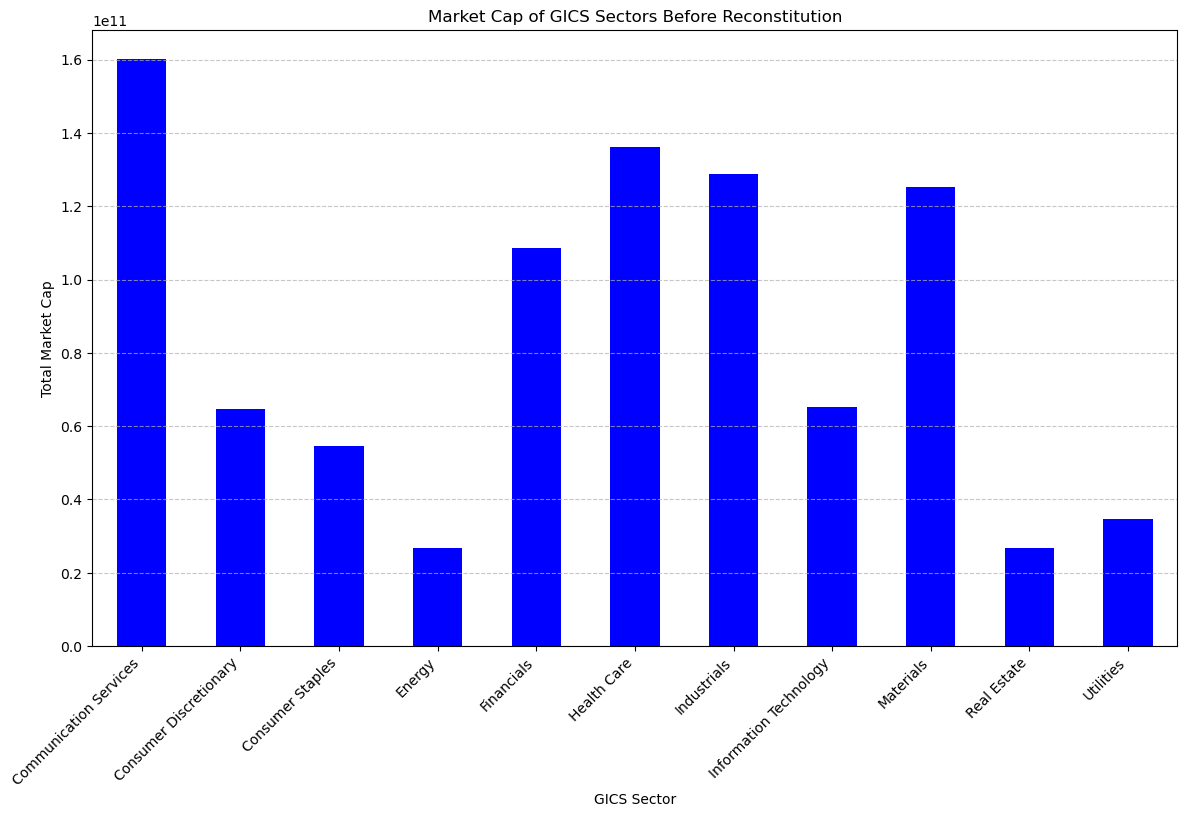

In [23]:
gics2023['Market Cap'] = pd.to_numeric(gics2023['Market Cap'], errors='coerce')
gics2023 = gics2023.dropna(subset=['Market Cap'])

# Group by GICS Sector and sum the Market Cap
sector_market_cap2023 = gics2023.groupby('GICS Sector')['Market Cap'].sum()

# Sort the sectors alphabetically
sector_market_cap2023 = sector_market_cap2023.sort_index()

# Convert the series to a dataframe for display
sector_market_cap_df2023 = sector_market_cap2023.reset_index()

total_market_cap2023 = sector_market_cap2023.sum()
sector_market_cap_df2023['Market Cap Percentage'] = (sector_market_cap_df2023['Market Cap'] / total_market_cap2023) * 100

# Plotting
plt.figure(figsize=(14, 8))
sector_market_cap2023.plot(kind='bar', color='blue')
plt.ylabel('Total Market Cap')
plt.xlabel('GICS Sector')
plt.title('Market Cap of GICS Sectors Before Reconstitution')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [24]:
print("Market Cap of GICS Sectors Before Reconstitution")
sector_market_cap_df2023

Market Cap of GICS Sectors Before Reconstitution


,GICS Sector,Market Cap,Market Cap Percentage
0,Communication Services,1.600698e+11,17.181365
1,Consumer Discretionary,6.459658e+10,6.933584
2,Consumer Staples,5.456526e+10,5.856855
3,Energy,2.667237e+10,2.862925
4,Financials,1.087267e+11,11.670367
5,Health Care,1.362177e+11,14.621158
6,Industrials,1.288107e+11,13.826121
7,Information Technology,6.529203e+10,7.008232
8,Materials,1.251385e+11,13.431960
9,Real Estate,2.686588e+10,2.883695


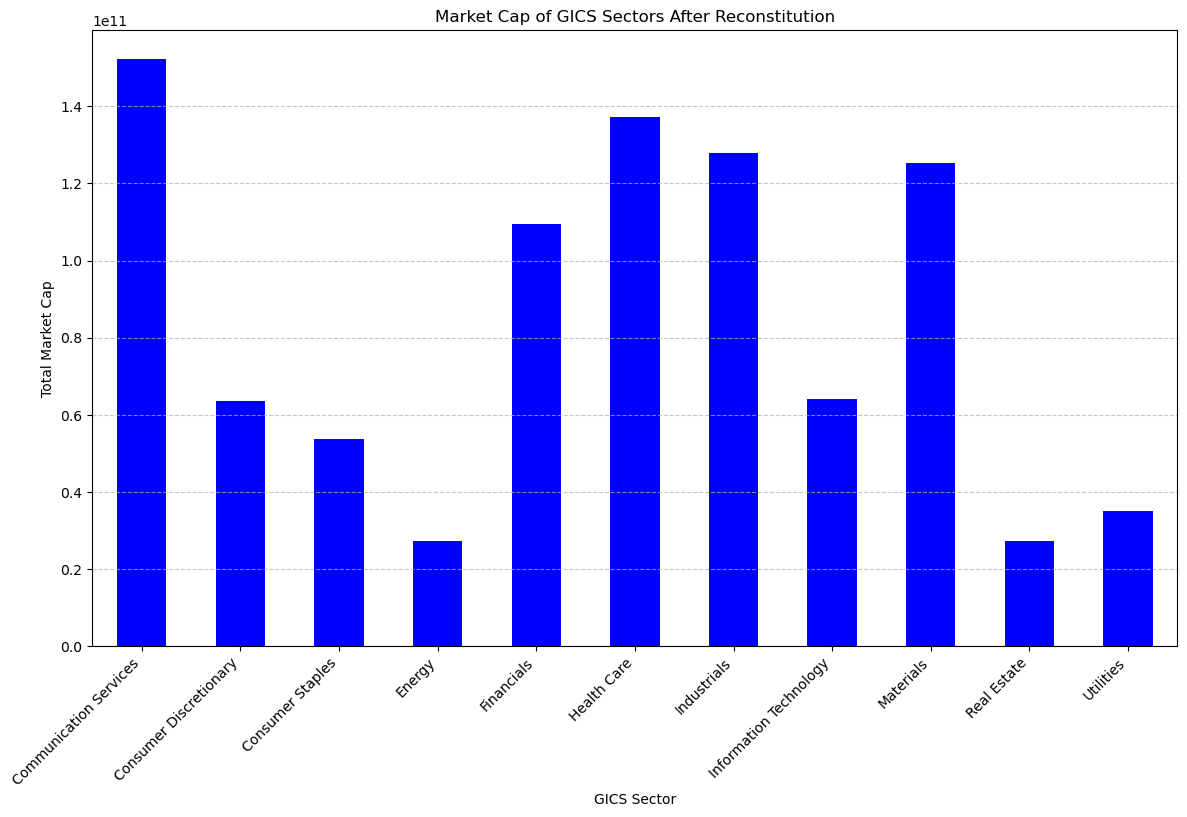

In [25]:
gics2024['Market Cap'] = pd.to_numeric(gics2024['Market Cap'], errors='coerce')
gics2024 = gics2024.dropna(subset=['Market Cap'])

# Group by GICS Sector and sum the Market Cap
sector_market_cap2024 = gics2024.groupby('GICS Sector')['Market Cap'].sum()

# Sort the sectors alphabetically
sector_market_cap2024 = sector_market_cap2024.sort_index()

# Convert the series to a dataframe for display
sector_market_cap_df2024 = sector_market_cap2024.reset_index()

total_market_cap2024 = sector_market_cap2024.sum()
sector_market_cap_df2024['Market Cap Percentage'] = (sector_market_cap_df2024['Market Cap'] / total_market_cap2024) * 100

# Plotting
plt.figure(figsize=(14, 8))
sector_market_cap2024.plot(kind='bar', color='blue')
plt.ylabel('Total Market Cap')
plt.xlabel('GICS Sector')
plt.title('Market Cap of GICS Sectors After Reconstitution')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [26]:
print("Market Cap of GICS Sectors After Reconstitution")
sector_market_cap_df2024

Market Cap of GICS Sectors After Reconstitution


,GICS Sector,Market Cap,Market Cap Percentage
0,Communication Services,1.521923e+11,16.486159
1,Consumer Discretionary,6.351193e+10,6.879898
2,Consumer Staples,5.365041e+10,5.811655
3,Energy,2.728513e+10,2.955648
4,Financials,1.095892e+11,11.871196
5,Health Care,1.372054e+11,14.862711
6,Industrials,1.279555e+11,13.860721
7,Information Technology,6.416469e+10,6.950609
8,Materials,1.253307e+11,13.576384
9,Real Estate,2.724951e+10,2.951790


In [31]:
top102023 = eod_market_cap_pivot2023.tail(1).T.reset_index().head(100)
top102023.columns = ['Ticker','Market Cap']
top102023 = top102023.sort_values('Market Cap',ascending=False).head(10)
top102023['Percentage of Index'] = round(top102023['Market Cap'] / total_market_cap2023 * 100,2)
print("Top 10 Companies Before Reconstitution")
top102023.set_index('Ticker')

Top 10 Companies Before Reconstitution


,Market Cap,Percentage of Index
Ticker,,
CMCSA,1.600698e+11,17.18
PNC,6.156206e+10,6.61
APD,5.709931e+10,6.13
AME,3.829353e+10,4.11
COR,3.826173e+10,4.11
HWM,3.033306e+10,3.26
PPG,2.962020e+10,3.18
WAB,2.799959e+10,3.01
ANSS,2.776879e+10,2.98


In [32]:
top102024 = eod_market_cap_pivot2024.head(1).T.reset_index().head(100)
top102024.columns = ['Ticker','Market Cap']
top102024 = top102024.sort_values('Market Cap',ascending=False).head(10)
top102024['Percentage of Index'] = round(top102024['Market Cap'] / total_market_cap2024 * 100,2)
print("Top 10 Companies After Reconstitution")
top102024.set_index('Ticker')

Top 10 Companies After Reconstitution


,Market Cap,Percentage of Index
Ticker,,
CMCSA,1.521923e+11,16.49
PNC,6.149027e+10,6.66
APD,5.712909e+10,6.19
COR,3.871993e+10,4.19
AME,3.841052e+10,4.16
HWM,3.130810e+10,3.39
PPG,2.956427e+10,3.20
ANSS,2.787102e+10,3.02
WAB,2.755406e+10,2.98


# Done Reporting

In [26]:
eod_market_cap_pivot = pd.DataFrame()
eod_market_cap_pivot = pd.concat([eod_market_cap_pivot2023,eod_market_cap_pivot2024.iloc[1:]])
eod_market_cap_pivot

Ticker,AA,ACRS,AEO,AHCO,AME,ANSS,APD,ARMK,AUR,AVTR,AWI,AXTA,BDN,BSY,BV,CABA,CCNE,CEIX,CMCSA,CNX,COHR,COR,CRS,CTLP,CUBE,CUBI,DGICA,DKS,DORM,DUOL,ECVT,ENS,EPAM,EQT,ESNT,ETRN,FCF,FIVE,FMC,FNB,FOLD,FOUR,FULT,GLPI,GMED,HCSG,HLNE,HRMY,HSY,HT,HWM,IRT,KHC,KMT,KOP,KRYS,KWR,LMB,LNC,LTHM,MATW,MDGL,MLYS,MNTK,MPB,MSA,NVRI,NWBI,OFLX,OLLI,OSUR,PENN,PFIS,PNC,PPG,PPL,RDN,SEIC,SEM,STBA,TFX,TGI,TOL,UGI,UHS,UHT,URBN,UTZ,UVSP,VPG,VSH,VSTS,VTRS,WAB,WCC,WMK,WST,WTRG,X,YORW,mkt_cap_deleted_stock,close_mkt_cap,adj_mkt_cap,divisor,gross_index_level,Index Value,AVBP,LRMR,OCGN,VERX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-10,4.351981e+09,3.039768e+08,3.363481e+09,5.400685e+08,3.463898e+10,2.519369e+10,5.877773e+10,7.404130e+09,1.265278e+09,1.246463e+10,3.572802e+09,6.578822e+09,6.471881e+08,1.156966e+10,2.841525e+08,6.845609e+08,4.017577e+08,2.312523e+09,1.711415e+11,3.224744e+09,5.060722e+09,3.354949e+10,3.176607e+09,3.771882e+08,8.132981e+09,1.189177e+09,2.169072e+08,6.677289e+09,1.757105e+09,7.224892e+09,9.060021e+08,3.452831e+09,1.330967e+10,1.597466e+10,5.022412e+09,3.593891e+09,1.235885e+09,9.617555e+09,6.351075e+09,3.953858e+09,2.982597e+09,3.161326e+09,2.148591e+09,1.135825e+10,5.144362e+09,7.024324e+08,3.035520e+09,7.925971e+08,2.822223e+10,3.770825e+08,1.935364e+10,2.892871e+09,2.586828e+10,1.804297e+09,8.281160e+08,2.404068e+09,2.262460e+09,3.437257e+08,3.692588e+09,2.449280e+09,1.095228e+09,2.170715e+09,1.180018e+08,3.863620e+08,2.879356e+08,5.941452e+09,4.560458e+08,1.334157e+09,2.146614e+08,4.837328e+09,4.541105e+08,3.536423e+09,2.675167e+08,4.764296e+10,3.030724e+10,1.843560e+10,4.140823e+09,6.831256e+09,2.279472e+09,9.878336e+08,9.373991e+09,7.653333e+08,8.583942e+09,4.291579e+09,7.718202e+09,4.980319e+08,2.372199e+09,8.204063e+08,5.001413e+08,3.277203e+08,2.750659e+09,2.165152e+09,1.101429e+10,1.995867e+10,7.131015e+09,1.004864e+09,2.510139e+10,8.160424e+09,6.824687e+09,4.263299e+08,0.000000e+00,8.508403e+11,8.508403e+11,1.000000,8.508403e+11,100.000000,NaN,NaN,NaN,NaN
2023-11-13,4.344916e+09,4.113606e+07,3.269347e+09,5.958834e+08,3.477221e+10,2.513666e+10,5.867809e+10,7.406726e+09,1.286250e+09,1.249485e+10,3.539684e+09,6.662769e+09,6.261482e+08,1.151613e+10,2.843505e+08,6.677149e+08,3.987355e+08,2.294869e+09,1.694256e+11,3.220118e+09,5.035404e+09,3.377024e+10,3.255606e+09,3.760076e+08,8.066006e+09,1.192049e+09,2.158521e+08,6.553283e+09,1.759997e+09,7.292913e+09,9.224189e+08,3.473809e+09,1.327574e+10,1.624403e+10,5.004778e+09,3.657921e+09,1.253811e+09,9.360223e+09,6.349836e+09,3.939712e+09,2.945315e+09,3.247945e+09,2.157394e+09,1.130804e+10,5.098950e+09,7.134885e+08,3.019041e+09,8.079290e+08,2.870199e+10,3.770825e+08,1.966220e+10,2.791425e+09,2.613963e+10,1.786104e+09,8.169199e+08,2.430411e+09,2.286474e+09,3.342462e+08,3.669100e+09,2.308558e+09,1.091996e+09,2.289109e+09,1.167172e+08,5.205324e+08,2.901358e+08,6.040859e+09,4.470500e+08,1.335412e+09,2.141319e+08,4.867457e+09,4.597254e+08,3.420034e+09,2.711761e+08,4.730280e+10,3.041547e+10,1.815198e+10,4.111202e+09,6.786576e+09,2.276351e+09,9.944733e+08,9.553476e+09,7.886621e+08,8.502749e+09,4.291579e+09,7.671982e+09,4.961222e+08,2.292478e+09,8.237467e+08,5.005677e+08,3.350809e+08,2.692287e+09,2.126070e+09,1.070950e+10,2.006507e+10,7.107784e+09,1.000625e+09,2.483836e+10,8.109558e+09,6.763185e+09,4.265636e+08,0.000000e+00,8.487627e+11,8.508403e+11,1.000000,8.487627e+11,99.755815,NaN,NaN,NaN,NaN
2023-11-14,4.623979e+09,4.351668e+07,3.374342e+09,6.650625e+08,3.553711e+10,2.575537e+10,5.942319e+10,6.799234e+09,1.502955e+09,1.263924e+10,3.687613e+09,6.810782e+09,7.145159e+08,1.187518e+10,3.085084e+08,6.688635e+08,4.303684e+08,2.408052e+09,1.710598e+11,3.280263e+09,5.275185e+09,3.299760e+10,3.338412e+09,3.972577e+08,8.610735e+09,1.270179e+09,2.211278e+08,6.761541e+09,1.870967e+09,7.496291e+09,9.819298e+08,3.759427e+09,1.400979e+10,1.628893e+10,5.137548e+09,3.705426e+09,1.334477e+09,9.920585e+09,6.540715e+09,4.166051e

In [27]:
index_df = eod_market_cap_pivot[['Index Value']].copy()
index_df

Ticker,Index Value
Date,
2023-11-10,100.000000
2023-11-13,99.755815
2023-11-14,102.269793
2023-11-15,102.990948
2023-11-16,102.824421
2023-11-17,103.129197
2023-11-20,103.675161
2023-11-21,103.323209
2023-11-22,103.430614


In [28]:
# pathhh = os.path.join(os.getcwd(), 'input/input2023.xlsx')

In [29]:
# eod_market_cap_pivot.to_excel(pathhh, index=True)

In [30]:
unique_dates[:]

['2023-11-10',
 '2023-11-13',
 '2023-11-14',
 '2023-11-15',
 '2023-11-16',
 '2023-11-17',
 '2023-11-20',
 '2023-11-21',
 '2023-11-22',
 '2023-11-24',
 '2023-11-27',
 '2023-11-28',
 '2023-11-29',
 '2023-11-30',
 '2023-12-01',
 '2023-12-04',
 '2023-12-05',
 '2023-12-06',
 '2023-12-07',
 '2023-12-08',
 '2023-12-11',
 '2023-12-12',
 '2023-12-13',
 '2023-12-14',
 '2023-12-15',
 '2023-12-18',
 '2023-12-19',
 '2023-12-20',
 '2023-12-21',
 '2023-12-22',
 '2023-12-26',
 '2023-12-27',
 '2023-12-28',
 '2023-12-29',
 '2024-01-02',
 '2024-01-03',
 '2024-01-04',
 '2024-01-05',
 '2024-01-08',
 '2024-01-09',
 '2024-01-10',
 '2024-01-11',
 '2024-01-12',
 '2024-01-16',
 '2024-01-17',
 '2024-01-18',
 '2024-01-19',
 '2024-01-22',
 '2024-01-23',
 '2024-01-24',
 '2024-01-25',
 '2024-01-26',
 '2024-01-29',
 '2024-01-30',
 '2024-01-31',
 '2024-02-01',
 '2024-02-02',
 '2024-02-05',
 '2024-02-06',
 '2024-02-07',
 '2024-02-08',
 '2024-02-09',
 '2024-02-12',
 '2024-02-13',
 '2024-02-14',
 '2024-02-15',
 '2024-02-

In [31]:
    start_2023 = '2023-11-10'
    end_2023 = '2024-06-28'
    start_2024 = '2024-06-28'
    
    excel_file_path2023 = 'input/RAY as of Oct 23 20231_PA.xlsx'
    df2023 = pd.read_excel(excel_file_path2023)
    df2023 = df2023.sort_values('Market Cap\n',ascending=False)
    df2023.columns = df2023.columns.str.rstrip('\n')
    df2023['Ticker'] = df2023['Ticker'].str.split(' ',n=1,expand=True)[0].replace(' ','')
    float_df2023 = df2023[['Ticker','Equity Float']].head(100)
    
    eod_market_cap_pivot2023 = pd.DataFrame()

    excel_file_path2024 = 'input/RAY as of Jul 01 20241_PA.xlsx'
    df2024 = pd.read_excel(excel_file_path2024)
    df2024 = df2024.sort_values('Market Cap\n',ascending=False)
    df2024.columns = df2024.columns.str.rstrip('\n')
    df2024['Ticker'] = df2024['Ticker'].str.split(' ',n=1,expand=True)[0].replace(' ','')
    float_df2024 = df2024[['Ticker','Equity Float']].head(100)

    eod_market_cap_pivot2024 = pd.DataFrame()
    
    unique_dates = list(date_dataframes.keys())




    
    for date in unique_dates:

        if date >= start_2023 and date <= end_2023:
    
            eod_df2023 = date_dataframes[date]

            merged_df2023 = pd.merge(float_df2023,eod_df2023,left_on='Ticker',right_on='underlying_symbol')
    
            merged_df2023['Market Cap'] = merged_df2023['Equity Float'] * merged_df2023['close']
        
            eod_market_cap_daily2023 = merged_df2023.pivot_table(values='Market Cap',index='quote_date',columns='Ticker',aggfunc='sum')
    
            eod_market_cap_pivot2023 = pd.concat([eod_market_cap_pivot2023,eod_market_cap_daily2023])
    
    eod_market_cap_pivot2023 = eod_market_cap_pivot2023.rename_axis(index='Date')
    eod_market_cap_pivot2023.index = pd.to_datetime(eod_market_cap_pivot2023.index,errors='coerce')
    
    
    eod_market_cap_pivot2023['mkt_cap_deleted_stock'] = 0
    
    for ticker in float_df2023['Ticker']:
        last_valid_market_cap = None
        first_deletion = False
    
        for date_index, date in enumerate(eod_market_cap_pivot2023.index):
    
            if date != eod_market_cap_pivot2023.index[-1]:
            
                next_date = eod_market_cap_pivot2023.index[date_index + 1]
            
                market_cap = eod_market_cap_pivot2023.at[date,ticker]
    
                market_cap_next_date = eod_market_cap_pivot2023.at[next_date,ticker]
    
                if (pd.isna(market_cap) or market_cap == 0) and (pd.isna(market_cap_next_date) or market_cap_next_date == 0):
                    if not first_deletion and last_valid_market_cap is not None:
                        eod_market_cap_pivot2023.at[date, 'mkt_cap_deleted_stock'] = last_valid_market_cap
                        first_deletion = True
    
                if (pd.isna(market_cap) or market_cap == 0) and market_cap_next_date != 0:
                    if not first_deletion and last_valid_market_cap is not None:
                        eod_market_cap_pivot2023.at[date,ticker] = last_valid_market_cap
                        first_deletion = True
                
                else:
                    last_valid_market_cap = market_cap
                    first_deletion = False
    
            else:
                market_cap = eod_market_cap_pivot2023.at[date,ticker]
                if pd.isna(market_cap) or market_cap == 0:
                    if not first_deletion and last_valid_market_cap is not None:
                        eod_market_cap_pivot2023.at[date,ticker] = last_valid_market_cap
                        first_deletion = True
                else:
                    last_valid_market_cap = market_cap
                    first_deletion = False
    
    eod_market_cap_pivot2023["close_mkt_cap"] = eod_market_cap_pivot2023.drop(columns='mkt_cap_deleted_stock').sum(axis=1)
    
    
    eod_market_cap_pivot2023["adj_mkt_cap"] = 0
    eod_market_cap_pivot2023["divisor"] = 0
    eod_market_cap_pivot2023["gross_index_level"] = 0
    eod_market_cap_pivot2023["Index Value"] = 0
    
    
    for i in range(0, len(eod_market_cap_pivot2023)):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            if i == 0:
                eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "adj_mkt_cap"] = float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "close_mkt_cap"]) + float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "mkt_cap_deleted_stock"])
                eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "divisor"] = 1
                eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "gross_index_level"] = float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "close_mkt_cap"]) / float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "divisor"])
                eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "Index Value"] = float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "gross_index_level"]) / (float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[0], "close_mkt_cap"]) / 100)
            else:
                eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "adj_mkt_cap"] = float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i-1], "close_mkt_cap"]) - float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "mkt_cap_deleted_stock"])
                eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "divisor"] = (float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "adj_mkt_cap"]) / float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i-1], "close_mkt_cap"])) * float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i-1], "divisor"])
                eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "gross_index_level"] = float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "close_mkt_cap"]) / float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "divisor"])
                eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "Index Value"] = float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[i], "gross_index_level"]) / (float(eod_market_cap_pivot2023.at[eod_market_cap_pivot2023.index[0], "close_mkt_cap"]) / 100)


    for date in unique_dates:
    
        if date >= start_2024:
        
            eod_df2024 = date_dataframes[date]
    
            merged_df2024 = pd.merge(float_df2024,eod_df2024,left_on='Ticker',right_on='underlying_symbol')
    
            merged_df2024['Market Cap'] = merged_df2024['Equity Float'] * merged_df2024['close']
        
            eod_market_cap_daily2024 = merged_df2024.pivot_table(values='Market Cap',index='quote_date',columns='Ticker',aggfunc='sum')
    
            eod_market_cap_pivot2024 = pd.concat([eod_market_cap_pivot2024,eod_market_cap_daily2024])
    
    eod_market_cap_pivot2024 = eod_market_cap_pivot2024.rename_axis(index='Date')
    eod_market_cap_pivot2024.index = pd.to_datetime(eod_market_cap_pivot2024.index,errors='coerce')
    
    
    eod_market_cap_pivot2024['mkt_cap_deleted_stock'] = 0
    
    for ticker in float_df2024['Ticker']:
        last_valid_market_cap = None
        first_deletion = False
    
        for date_index, date in enumerate(eod_market_cap_pivot2024.index):
    
            if date != eod_market_cap_pivot2024.index[-1]:
            
                next_date = eod_market_cap_pivot2024.index[date_index + 1]
            
                market_cap = eod_market_cap_pivot2024.at[date,ticker]
    
                market_cap_next_date = eod_market_cap_pivot2024.at[next_date,ticker]
    
                if (pd.isna(market_cap) or market_cap == 0) and (pd.isna(market_cap_next_date) or market_cap_next_date == 0):
                    if not first_deletion and last_valid_market_cap is not None:
                        eod_market_cap_pivot2024.at[date, 'mkt_cap_deleted_stock'] = last_valid_market_cap
                        first_deletion = True
    
                if (pd.isna(market_cap) or market_cap == 0) and market_cap_next_date != 0:
                    if not first_deletion and last_valid_market_cap is not None:
                        eod_market_cap_pivot2024.at[date,ticker] = last_valid_market_cap
                        first_deletion = True
                
                else:
                    last_valid_market_cap = market_cap
                    first_deletion = False
    
            else:
                market_cap = eod_market_cap_pivot2024.at[date,ticker]
                if pd.isna(market_cap) or market_cap == 0:
                    if not first_deletion and last_valid_market_cap is not None:
                        eod_market_cap_pivot2024.at[date,ticker] = last_valid_market_cap
                        first_deletion = True
                else:
                    last_valid_market_cap = market_cap
                    first_deletion = False
    
    eod_market_cap_pivot2024["close_mkt_cap"] = eod_market_cap_pivot2024.drop(columns='mkt_cap_deleted_stock').sum(axis=1)
    
    
    eod_market_cap_pivot2024["adj_mkt_cap"] = 0
    eod_market_cap_pivot2024["divisor"] = 0
    eod_market_cap_pivot2024["gross_index_level"] = 0
    eod_market_cap_pivot2024["Index Value"] = 0
    
    
    for i in range(0, len(eod_market_cap_pivot2024)):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            if i == 0:
                eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "adj_mkt_cap"] = float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "close_mkt_cap"]) + float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "mkt_cap_deleted_stock"])
                eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "divisor"] = 1
                eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "gross_index_level"] = float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "close_mkt_cap"]) / float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "divisor"])
                eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "Index Value"] = float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "gross_index_level"]) / (float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[0], "close_mkt_cap"]) / last_value)
            else:
                eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "adj_mkt_cap"] = float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i-1], "close_mkt_cap"]) - float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "mkt_cap_deleted_stock"])
                eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "divisor"] = (float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "adj_mkt_cap"]) / float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i-1], "close_mkt_cap"])) * float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i-1], "divisor"])
                eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "gross_index_level"] = float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "close_mkt_cap"]) / float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "divisor"])
                eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "Index Value"] = float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[i], "gross_index_level"]) / (float(eod_market_cap_pivot2024.at[eod_market_cap_pivot2024.index[0], "close_mkt_cap"]) / last_value)



    eod_market_cap_pivot = pd.DataFrame()
    eod_market_cap_pivot = pd.concat([eod_market_cap_pivot2023,eod_market_cap_pivot2024.iloc[1:]])

eod_market_cap_pivot

index_df = eod_market_cap_pivot[["Index Value"]].copy()
index_df

C:\Users\micha\AppData\Local\Temp\ipykernel_6604\1773761835.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2938245904.56' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eod_market_cap_pivot2023.at[date, 'mkt_cap_deleted_stock'] = last_valid_market_cap


Ticker,Index Value
Date,
2023-11-10,100.000000
2023-11-13,99.755815
2023-11-14,102.269793
2023-11-15,102.990948
2023-11-16,102.824421
2023-11-17,103.129197
2023-11-20,103.675161
2023-11-21,103.323209
2023-11-22,103.430614


In [32]:
    excel_file_path = 'input/RAY as of Oct 23 20231_PA.xlsx'
    df = pd.read_excel(excel_file_path)
    #df = pd.read_excel("/srv/paindex-test/data/RAY as of Oct 23 20231_PA.xlsx")
    df.columns = df.columns.str.rstrip('\n')
    df['Ticker'] = df['Ticker'].str.split(' ', n=1, expand=True)[0]
    df['Ticker'] = df['Ticker'].str.replace(' ', '')  # Remove spaces
    # Create float_df by selecting the first 100 rows of "Ticker" and "Equity Float" columns
    float_df = df[['Ticker', 'Equity Float']].head(100)
    float_df
    # Create an empty DataFrame to store market cap DataFrames for each date
    eod_market_cap_pivot = pd.DataFrame()

    # Extract unique dates from date_dataframes dictionary
    unique_dates = list(date_dataframes.keys())

    # Iterate over unique dates
    for date_format in unique_dates[:]:
        # Access the corresponding DataFrame from date_dataframes
        eod_df = date_dataframes[date_format]

        # Merge dataframes on the common column 'Ticker' and 'underlying_symbol'
        merged_df = pd.merge(float_df, eod_df, left_on='Ticker', right_on='underlying_symbol')

        # Perform the multiplication and rename the column to 'Market Cap'
        merged_df['Market Cap'] = merged_df['Equity Float'] * merged_df['close']

        # Use pivot_table to create a multi-level DataFrame
        eod_market_cap_daily = merged_df.pivot_table(index='quote_date', columns='Ticker', values='Market Cap', aggfunc='sum')

        # Add a new column for the sum of market caps for each date
        #eod_market_cap_daily['close index market cap'] = eod_market_cap_daily.sum(axis=1)

        # Append the daily market cap DataFrame to the main DataFrame
        eod_market_cap_pivot = pd.concat([eod_market_cap_pivot, eod_market_cap_daily])

    # Rename the index to 'Date'
    eod_market_cap_pivot = eod_market_cap_pivot.rename_axis(index='Date')

    # Display the resulting pivot table
    eod_market_cap_pivot.index = pd.to_datetime(eod_market_cap_pivot.index, errors='coerce')
    #eod_market_cap_pivot.index.name = None  # Remove the index name

    # Display the resulting pivot table
    eod_market_cap_pivot


    # Ensure the index is in DateTime format
    eod_market_cap_pivot.index = pd.to_datetime(eod_market_cap_pivot.index)
    # Assuming eod_market_cap_pivot is your DataFrame and float_df["Ticker"] is the DataFrame with Ticker information

    # Step 1: Calculate the close market cap
    eod_market_cap_pivot["close_market_cap"] = eod_market_cap_pivot.sum(axis=1)

    # Step 2: Calculate the gross change mkt cap
    eod_market_cap_pivot["gross_change_mkt_cap"] = eod_market_cap_pivot["close_market_cap"].diff().fillna(0)

    # Step 3: Calculate the mkt_cap_deleted_stock

#     mkt_cap_deleted_stock = {}
#     for date in eod_market_cap_pivot.index:
#         for ticker in float_df["Ticker"]:
#             if pd.isna(eod_market_cap_pivot.at[date, ticker]) or eod_market_cap_pivot.at[date, ticker] == 0:
#                 if ticker not in mkt_cap_deleted_stock:
#                     # Get the most recent non-zero market cap for the Ticker
#                     non_zero_caps = eod_market_cap_pivot.loc[:date, ticker].replace({0: pd.NA}).dropna()
#                     if not non_zero_caps.empty:
#                         mkt_cap_deleted_stock[ticker] = (non_zero_caps.iloc[-1], date)
#                     else:
#                         mkt_cap_deleted_stock[ticker] = (0, date)

#     # Prepare a column for the summed market caps
#     eod_market_cap_pivot["mkt_cap_deleted_stock"] = 0

#     # Populate the new column in the eod_market_cap_pivot dataframe
#     for ticker, (market_cap, cap_date) in mkt_cap_deleted_stock.items():
#         # This line assumes 'cap_date' matches an index exactly in eod_market_cap_pivot
#         if cap_date in eod_market_cap_pivot.index:
#             eod_market_cap_pivot.at[cap_date, "mkt_cap_deleted_stock"] += market_cap

#     # Make the values negative
#     eod_market_cap_pivot["mkt_cap_deleted_stock"] = -eod_market_cap_pivot["mkt_cap_deleted_stock"]

#     # Set mkt_cap_deleted_stock to 0 if it is NaN
#     eod_market_cap_pivot["mkt_cap_deleted_stock"] = eod_market_cap_pivot["mkt_cap_deleted_stock"].fillna(0)

# Initialization of the result column in the DataFrame
    eod_market_cap_pivot['mkt_cap_deleted_stock'] = 0

    # Iterate over each ticker
    for ticker in float_df['Ticker']:
        # Track the last valid market cap
        last_valid_market_cap = None
        # Flag to mark the first deletion occurrence
        first_deletion = False

        # Iterate through each date
        for date in eod_market_cap_pivot.index:
            market_cap = eod_market_cap_pivot.at[date, ticker]

            # Check if market cap is zero or NaN
            if pd.isna(market_cap) or market_cap == 0:
                if not first_deletion and last_valid_market_cap is not None:
                    # Mark the first deletion and update the DataFrame
                    eod_market_cap_pivot.at[date, 'mkt_cap_deleted_stock'] = -last_valid_market_cap
                    first_deletion = True
            else:
                # Reset on finding a non-zero market cap
                last_valid_market_cap = market_cap
                first_deletion = False  # Reset the deletion flag on valid data

    # Step 4: Calculate adj_mkt_cap
    #eod_market_cap_pivot["mkt_cap_deleted_stock"][4] = -50000000000
    #eod_market_cap_pivot["mkt_cap_deleted_stock"][4] = 5000000000
    eod_market_cap_pivot["adj_mkt_cap"] = eod_market_cap_pivot["close_market_cap"] + eod_market_cap_pivot["mkt_cap_deleted_stock"]

    # Step 5: Create gross_index_level column and set the first row value to be 100
    eod_market_cap_pivot["close_divisor"] = 0
    eod_market_cap_pivot["adj_divisor"] = 0
    eod_market_cap_pivot["gross_index_level"] = 0
    eod_market_cap_pivot["Index Value"] = 0
    # Temporarily filter out FutureWarnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        eod_market_cap_pivot.at[eod_market_cap_pivot.index[0], "gross_index_level"] = 100
        eod_market_cap_pivot.at[eod_market_cap_pivot.index[0], "Index Value"] = 100
        eod_market_cap_pivot.at[eod_market_cap_pivot.index[0], "close_divisor"] = float(eod_market_cap_pivot["close_market_cap"][0]) / float(eod_market_cap_pivot["gross_index_level"][0])
        eod_market_cap_pivot.at[eod_market_cap_pivot.index[0], "adj_divisor"] = float(eod_market_cap_pivot["close_divisor"][0]) * float(eod_market_cap_pivot["close_market_cap"][0]) / float(eod_market_cap_pivot["adj_mkt_cap"][0])

    # Iterate through rows starting from the second row
    for i in range(1, len(eod_market_cap_pivot)):
            # Temporarily filter out FutureWarnings
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            # Calculate close_divisor based on the previous day's adj_divisor
            eod_market_cap_pivot.at[eod_market_cap_pivot.index[i], "close_divisor"] = float(eod_market_cap_pivot.at[eod_market_cap_pivot.index[i-1], "adj_divisor"])

            # Calculate gross_index_level
            eod_market_cap_pivot.at[eod_market_cap_pivot.index[i], "gross_index_level"] = float(eod_market_cap_pivot.at[eod_market_cap_pivot.index[i], "close_market_cap"]) / float(eod_market_cap_pivot.at[eod_market_cap_pivot.index[i], "close_divisor"])

            # Calculate adj_divisor
            eod_market_cap_pivot.at[eod_market_cap_pivot.index[i], "adj_divisor"] = float(eod_market_cap_pivot.at[eod_market_cap_pivot.index[i], "adj_mkt_cap"]) / float(eod_market_cap_pivot.at[eod_market_cap_pivot.index[i], "close_market_cap"]) * float(eod_market_cap_pivot.at[eod_market_cap_pivot.index[i], "close_divisor"])

            # Calculate Index Value
            eod_market_cap_pivot.at[eod_market_cap_pivot.index[i], "Index Value"] = float(eod_market_cap_pivot.at[eod_market_cap_pivot.index[i], "adj_mkt_cap"]) / float(eod_market_cap_pivot.at[eod_market_cap_pivot.index[i], "adj_divisor"])

    eod_market_cap_pivot

index_df = eod_market_cap_pivot[["Index Value"]].copy()
index_df

C:\Users\micha\AppData\Local\Temp\ipykernel_6604\3057297699.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-243417757.38560003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  eod_market_cap_pivot.at[date, 'mkt_cap_deleted_stock'] = -last_valid_market_cap


Ticker,Index Value
Date,
2023-11-10,100.000000
2023-11-13,99.794327
2023-11-14,102.140534
2023-11-15,102.912644
2023-11-16,102.783860
2023-11-17,103.065570
2023-11-20,103.647055
2023-11-21,103.322953
2023-11-22,103.442105
